In [1]:
import datetime
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [45]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 45

In [3]:
data = pd.read_csv('../share/tpms-merged-5.csv')
cars = pd.read_csv('../data/cars.csv')
data.shape

(111903, 17)

## Sample Figure

In [40]:
def plot_pattern(
    pivot_table,
    offlines=None,
    title="Car",
    width=15,
    height=12,
    legend=True,
    legendx=0.5,
    legendy=1.2,
    save=False,
):
    f, ax = plt.subplots(figsize=(width, height))
    # Custom colormap: black for 'ID seen', gray for 'ID not seen'
    cmap = plt.cm.gray_r.copy()
    cmap.set_under("#ebebeb")  # Set the color for 'ID not seen' (value == 0)
    cmap.set_over("black")  # Set the color for 'ID seen' (value > 0)
    cmap.set_bad("#ebebeb")  # Set the color for background (invalid data)

    # Mask the values where the ID is not seen
    masked_data = np.ma.masked_where(pivot_table == 0, pivot_table)
    padded_data = np.pad(masked_data, pad_width=1, mode="constant", constant_values=0)

    # Plotting
    ax.imshow(
        padded_data,
        cmap=cmap,
        aspect="auto",
        vmin=0.1,
        extent=(-1.5, 24.5, len(pivot_table.index) + 1.0, -1.0),
    )

    # Setting the ticks and labels
    ax.set_xticks(ticks=np.arange(24), labels=[f"{hour}" for hour in range(24)])

    # Generate day labels with an empty string where no label is desired
    day_labels = [
        "Day{}".format(i + 1) if (i + 1) % 10 == 1 else ""
        for i in range(len(pivot_table.index))
    ]
    # Generate the corresponding tick positions for where we have labels
    day_ticks = [i + 0.5 for i, label in enumerate(day_labels) if label]
    # Apply labels and ticks to the y-axis.
    ax.set_yticks(
        ticks=day_ticks, labels=[label for i, label in enumerate(day_labels) if label]
    )

    # Removing minor ticks
    ax.tick_params(axis="y", which="both", left=False, labelleft=True)
    # Ensure the major ticks are shown where we have labels
    # ax.tick_params(axis='y', which='major', left=True)

    for i in range(len(pivot_table.columns)):
        plt.axvline(x=i, color="white", linewidth=1.0)

    # For white borders, draw horizontal lines at every 10th day
    for i in range(len(pivot_table.index)):
        if (i + 1) % 10 == 1:
            plt.axhline(y=i, color="white", linewidth=2.0)

    # Setting labels for axes and title
    ax.set_xlabel("Time")
    ax.set_xlim([4.5,21.5])
    ax.set_ylabel("Date")
    ax.set_title(f"{title[0:3]} {title[3:]}")

    # Highlighting offline and holiday hours with labels for the legend
    weekdays = pd.to_datetime(pivot_table.index)
    isweekend_mask = (
        weekdays.weekday == 5
    )  # We will draw a width 2 rectangle starting saturday
    first = True
    for i, day in enumerate(isweekend_mask):
        if day:  # In case the day is a weekend
            if first:
                ax.axhspan(i, i + 2, color="#619CFF", alpha=0.6, label="Weekend")
                first = False
            else:
                ax.axhspan(i, i + 2, color="#619CFF", alpha=0.6)

    first = True
    if offlines:
        for offline in offlines:
            if first:
                ax.axhspan(
                    offline[0], offline[1], color="#F8766D", alpha=0.7, label="Holiday/Parking Closed"
                )
                first = False
            else:
                ax.axhspan(offline[0], offline[1], color="#F8766D", alpha=0.7)

    # Create a white grid to simulate borders
    # plt.grid(which="major", color="white", linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(False)

    # Add the legend to the plot
    if legend:
        ax.legend(loc="upper center", bbox_to_anchor=(legendx, legendy), ncol=2, fancybox=True, fontsize=30)

    ax.invert_yaxis()

    # Show the plot with tight layout
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    if save:
        plt.savefig(f"../pics/patterns/r1/{title.lower()}.pdf", format="pdf", bbox_inches="tight")
        plt.close()
    else:
        plt.show()

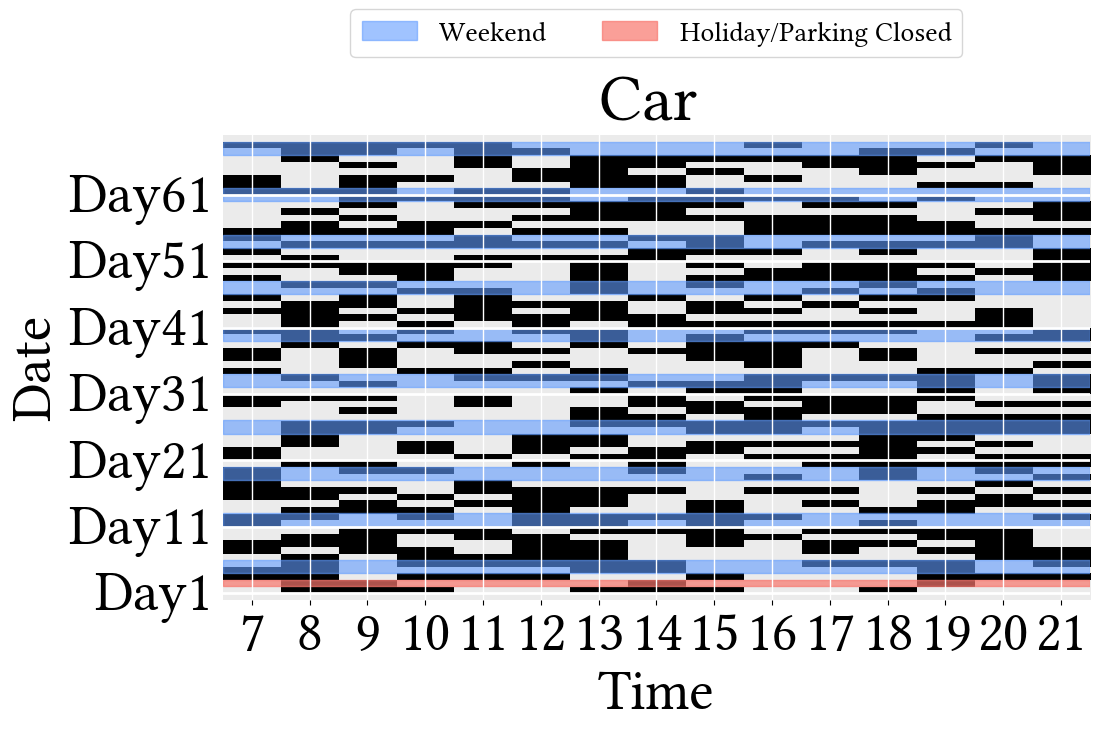

In [26]:
# Sample data creation
date_rng = pd.date_range(start="2023-10-25T00:00:00Z", end="2023-12-31T23:59:59Z", freq="H")
df_sample = pd.DataFrame(date_rng, columns=["date"])
df_sample["value"] = np.random.choice(
    [0, 1], size=(len(date_rng))
)  # 0 for 'ID not seen', 1 for 'ID seen'

df_sample = df_sample.set_index('date')
pivot_table = df_sample.pivot_table(
    values="value",
    index=df_sample.index.date,
    columns=df_sample.index.hour,
    aggfunc="sum",
)

weekdays = pd.date_range(start="2023-10-25T00:00:00Z", end="2023-12-31T23:59:59Z", freq="D")
weekends = (weekdays.weekday == 5) | (weekdays.weekday == 6)

plot_pattern(pivot_table, offlines=[[1,2]], width=12, height=9, legend=True, legendy=1.3)

## Getting Car Patterns

In [46]:
index = 0
car = cars.loc[index,['id1','id2','id3','id4']].to_numpy()
selected = data[data["id"].isin(car)]
selected = selected.set_index(pd.to_datetime(selected['time']))

In [47]:
t = selected.groupby(pd.Grouper(freq='1H')).size().to_frame()
t.index.name = None
t['value'] = t[0]
t.drop([0],axis=1,inplace=True)

t[t['value'] > 1] = 1

pivot_table = t.pivot_table(
    values="value",
    index=t.index.date,
    columns=t.index.hour,
    aggfunc="sum",
)

In [48]:
holidays_mask = (
    (pivot_table.index == datetime.date(2023, 11, 1))
    | (pivot_table.index == datetime.date(2023, 11, 9))
    | (pivot_table.index == datetime.date(2023, 11, 27))
    | (pivot_table.index == datetime.date(2023, 12, 6))
    | (pivot_table.index == datetime.date(2023, 12, 8))
    | (pivot_table.index == datetime.date(2023, 12, 25))
)
days = np.where(holidays_mask)[0]
offline = []
for day in days:
    offline.append([day, day + 1])

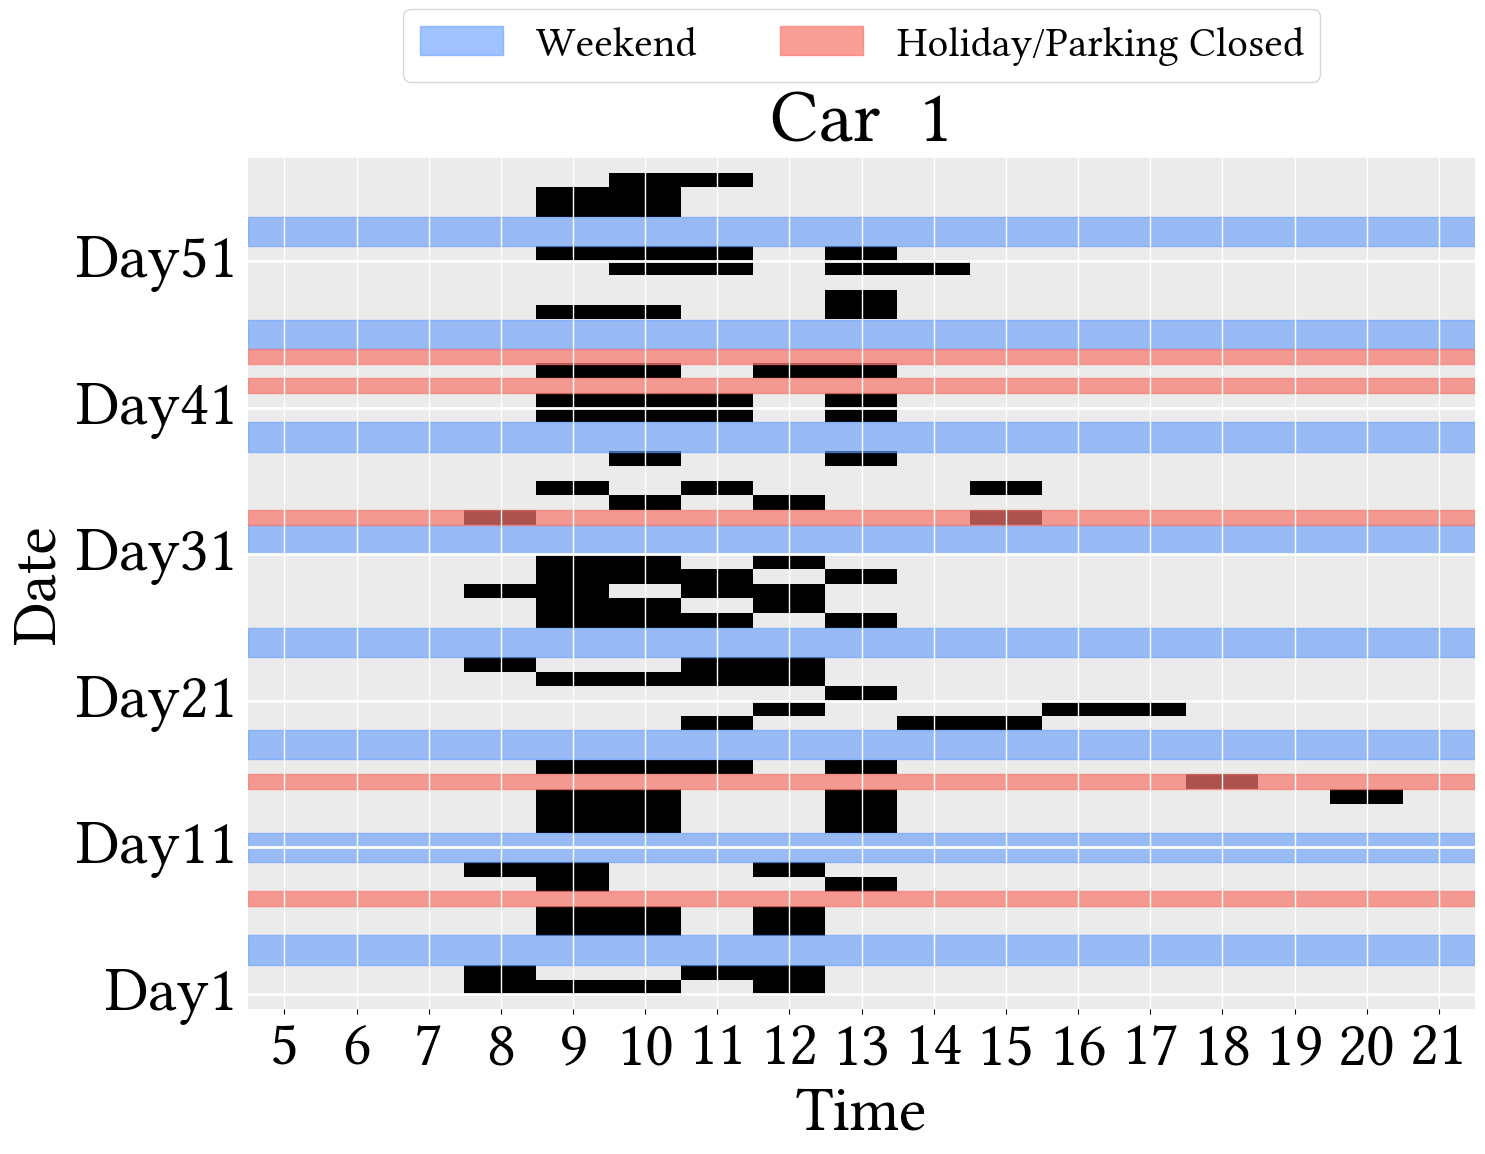

In [49]:
plot_pattern(pivot_table, offlines=offline, title=f'Car {index+1}', width=16, height=13, legendy=1.2)

## Getting all plots

In [50]:
last_date = pd.to_datetime(data['time'][len(data)-1])
for i in range(len(cars)):
    car = cars.loc[i, ["id1", "id2", "id3", "id4"]].to_numpy()
    selected = data[data["id"].isin(car)]
    selected = selected.set_index(pd.to_datetime(selected["time"]))

    t = selected.groupby(pd.Grouper(freq="1H")).size().to_frame()
    t.index.name = None
    t["value"] = t[0]
    t.drop([0], axis=1, inplace=True)

    t[t["value"] > 1] = 1

    pivot_table = t.pivot_table(
        values="value",
        index=t.index.date,
        columns=t.index.hour,
        aggfunc="sum",
    )
    pivot_table.index = pd.to_datetime(pivot_table.index)

    new_dates = pd.date_range(
        start=pivot_table.index[-1].date(),
        end=last_date.date(),
        periods=(last_date.date() - pivot_table.index[-1].date()).days + 2,
    )

    new_rows = pd.DataFrame(index=new_dates, columns=pivot_table.columns).fillna(
        0
    )  # Fill with 0s or any default value
    pivot_table = pd.concat([pivot_table, new_rows])
    pivot_table.index = pd.to_datetime(pivot_table.index)

    holidays_mask = (
        (pivot_table.index == pd.to_datetime('2023-11-01'))
        | (pivot_table.index == pd.to_datetime('2023-11-09'))
        | (pivot_table.index == pd.to_datetime('2023-11-27'))
        | (pivot_table.index == pd.to_datetime('2023-12-06'))
        | (pivot_table.index == pd.to_datetime('2023-12-08'))
        | (pivot_table.index == pd.to_datetime('2023-12-25'))
    )
    days = np.where(holidays_mask)[0]
    offline = []
    for day in days:
        offline.append([day, day + 1])

    plot_pattern(
        pivot_table,
        offlines=offline,
        title=f"Car{i+1}",
        width=16,
        height=14,
        legend=True,
        legendy=1.2,
        save=True,
    )

## Comparing 1 vs all ids

In [18]:
all_rx = np.zeros((13,1))
for i in range(13):
    car = cars.loc[i, ["id1", "id2", "id3", "id4"]].to_numpy()
    selected = data[data["id"].isin(car)]
    selected = selected.set_index(pd.to_datetime(selected["time"]))

    t = selected.groupby(pd.Grouper(freq="30s")).size().to_frame()
    t.index.name = None
    t["value"] = t[0]
    t.drop([0], axis=1, inplace=True)

    t[t["value"] > 1] = 1

    pivot_table = t.pivot_table(
        values="value",
        index=t.index.date,
        columns=t.index.hour,
        aggfunc="sum",
    )

    all_rx[i] = pivot_table.sum().sum()

In [19]:
one_rx = np.zeros((13,4))
for j in range(4):
    for i in range(13):
        car = cars.loc[i, ["id1", "id2", "id3", "id4"]].to_numpy()
        selected = data[data["id"].isin(car[j:j+1])]
        selected = selected.set_index(pd.to_datetime(selected["time"]))

        t = selected.groupby(pd.Grouper(freq="30s")).size().to_frame()
        t.index.name = None
        t["value"] = t[0]
        t.drop([0], axis=1, inplace=True)

        t[t["value"] > 1] = 1

        pivot_table = t.pivot_table(
            values="value",
            index=t.index.date,
            columns=t.index.hour,
            aggfunc="sum",
        )

        one_rx[i][j] = pivot_table.sum().sum()

In [42]:
two_rx = np.zeros((13,6))
j = 0
for comb in itertools.combinations([0,1,2,3], 2):
    for i in range(13):
        car = cars.loc[i, ["id1", "id2", "id3", "id4"]].to_numpy()
        selected = data[data["id"].isin(car[[comb]].squeeze())]
        selected = selected.set_index(pd.to_datetime(selected["time"]))

        t = selected.groupby(pd.Grouper(freq="30s")).size().to_frame()
        t.index.name = None
        t["value"] = t[0]
        t.drop([0], axis=1, inplace=True)

        t[t["value"] > 1] = 1

        pivot_table = t.pivot_table(
            values="value",
            index=t.index.date,
            columns=t.index.hour,
            aggfunc="sum",
        )

        two_rx[i][j] = pivot_table.sum().sum()
    j += 1

In [75]:
three_rx = np.zeros((13,4))
j = 0
for comb in itertools.combinations([0,1,2,3], 3):
    for i in range(13):
        car = cars.loc[i, ["id1", "id2", "id3", "id4"]].to_numpy()
        selected = data[data["id"].isin(car[[comb]].squeeze())]
        selected = selected.set_index(pd.to_datetime(selected["time"]))

        t = selected.groupby(pd.Grouper(freq="30s")).size().to_frame()
        t.index.name = None
        t["value"] = t[0]
        t.drop([0], axis=1, inplace=True)

        t[t["value"] > 1] = 1

        pivot_table = t.pivot_table(
            values="value",
            index=t.index.date,
            columns=t.index.hour,
            aggfunc="sum",
        )

        three_rx[i][j] = pivot_table.sum().sum()
    j += 1

In [85]:
one_rx_avg = (one_rx / all_rx).flatten()
two_rx_avg = (two_rx / all_rx).flatten()
three_rx_avg = (three_rx / all_rx).flatten()

res_one = stats.ecdf(one_rx_avg)
res_two = stats.ecdf(two_rx_avg)
res_three = stats.ecdf(three_rx_avg)

In [114]:
survival_one = 1 - res_one.cdf.probabilities
quantile_one = res_one.cdf.quantiles
quantile_one = np.insert(quantile_one, 0, 0)  # Insert 0 at the beginning of quantile array
quantile_one = np.append(quantile_one, 1)     # Append 1 at the end of quantile array
survival_one = np.insert(survival_one, 0, 1)  # Insert 1 at the beginning of survival array
survival_one = np.append(survival_one, 0)     # Append 0 at the end of survival array

survival_two = 1 - res_two.cdf.probabilities
quantile_two = res_two.cdf.quantiles
quantile_two = np.insert(quantile_two, 0, 0)  
quantile_two = np.append(quantile_two, 1)     
survival_two = np.insert(survival_two, 0, 1) 
survival_two = np.append(survival_two, 0)   


survival_three = 1 - res_three.cdf.probabilities
quantile_three = res_three.cdf.quantiles
quantile_three = np.insert(quantile_three, 0, 0)  
quantile_three = np.append(quantile_three, 1)     
survival_three = np.insert(survival_three, 0, 1) 
survival_three = np.append(survival_three, 0)   

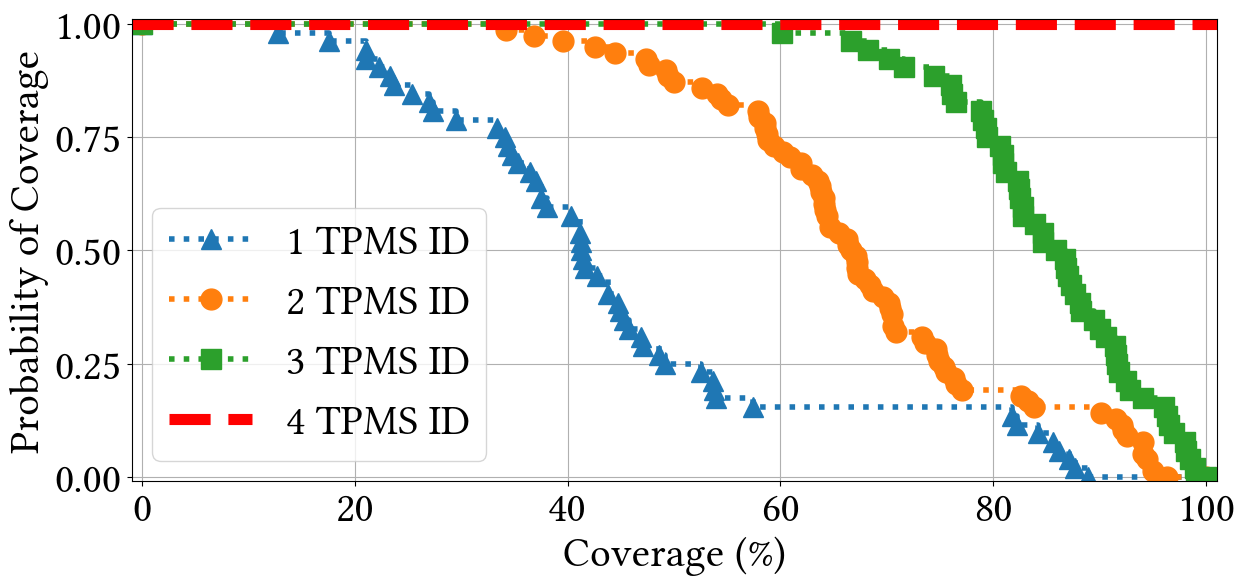

In [161]:
(f, ax) = plt.subplots(figsize=(14,6))
ax.grid()

ax.step(100*quantile_one, survival_one, where='post', label='1 TPMS ID', linewidth=4.0, linestyle=':', marker='^', markersize=15)
ax.step(100*quantile_two, survival_two, where='post', label='2 TPMS ID', linewidth=4.0, linestyle=':', marker='o', markersize=15)
ax.step(100*quantile_three, survival_three, where='post', label='3 TPMS ID', linewidth=4.0, linestyle=':', marker='s', markersize=15)
ax.axhline(y=1, color='r', linestyle='--', label='4 TPMS ID', linewidth=8.0)

ax.set_xlabel('Coverage (%)')
ax.set_xlim(100*-.01, 100*1.01)

ax.set_ylabel('Probability of Coverage')
ax.set_ylim(-.01, 1.01)

plt.legend()

plt.savefig('../pics/survivalcdf.pdf', format='pdf', bbox_inches='tight')
plt.show()